# Лабораторная работа 8
## NARX

## Вариант 3


Сутдент: Будникова Валерия Павловна 

группа: М8О-407Б-19  

### Цель работы: 

Построить и обучить нелинейную авторегрессионную сеть с внешними входами (Non-linear AutoRegressive network with eXogeneous inputs, NARX), которая будет выполнять аппроксимацию траектории динамической системы, также выполнить многошаговый прогноз значений системы.


### Задание:

$$ u(k) = sin(t^2 - 7 * t)  $$

$$ y(k) = \frac{y(t-1)}{1 + y^2(t-1)} + u^3(t-1)  $$

In [1]:
import torch as tr
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from ipywidgets import interact
from collections import deque

In [50]:
class TDL(tr.nn.Module):
    def __init__(self, in_features, len_deq = 1):
        super(TDL, self).__init__()
        self.in_features = in_features
        self.len_deq = len_deq
        self.line =  deque()
        self.clear()
    def clear(self):
        self.line.clear()
        for i in range(self.len_deq):
            self.line.append(tr.zeros(self.in_features))

    def push(self, inputs):
        self.line.appendleft(inputs)
    
    def forward(self, input = 0):
        return self.line.pop()

class NARX(tr.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, len_deq1, len_deq2):
        super(NARX, self).__init__()

        self.in_features = in_features
        self.hi_features = hidden_features
        self.out_features = out_features

        self.line1 = TDL(in_features, len_deq1)
        self.line2 = TDL(out_features, len_deq2)

        self.w1 = tr.nn.Parameter(tr.randn(in_features, hidden_features))
        self.w2 = tr.nn.Parameter(tr.randn(hidden_features, out_features))
        self.w3 = tr.nn.Parameter(tr.randn(out_features, hidden_features))

        self.b1 = tr.nn.Parameter(tr.ones(hidden_features))
        self.b2 = tr.nn.Parameter(tr.ones(out_features))

    def clear(self):
        self.line1.clear()
        self.line2.clear()

    def forward(self, inputs): 
        w1 = self.w1.cuda()
        w2 = self.w2.cuda()
        w3 = self.w3.cuda()
        b1 = self.b1.cuda()
        b2 = self.b2.cuda()
        l1 = self.line1().cuda()
        l2 = self.line2().cuda()
        out1 = tr.tanh(l1 @ w1 + l2 @ w3 + b1)
        out2 = out1 @ w2 + b2

        self.line1.push(tr.tensor(inputs))
        self.line2.push(tr.tensor(out2))

        return out2


Количество эпох = 200

In [ ]:
model = NARX(in_features = 5, hidden_features = 10, out_features = 5, len_deq1 = 3, len_deq2 = 3)

optim = tr.optim.Adam(model.parameters(), lr = 1e-3)


N, w = 1000, 5
t = np.linspace(0, 10, N)
uk, yk = np.sin(t**2 - 7 * t), [0]
for i in range(N-1):
    yk += [yk[-1] / (1 + yk[-1]**2) + uk[i] ** 3]

train_data = [(np.array(uk[i: i+w], dtype = np.float32), np.array(yk[i: i + w], dtype=np.float32)) for i in range(N - 5)]


train_dataloader = tr.utils.data.DataLoader(dataset = train_data, batch_size = 1, shuffle = False)

model.cuda()

model.train()

train_loss = []

epoch = 200

for i in tqdm(range(epoch)):
    model.clear()

    ep_loss = []

    for inputs, outputs in train_dataloader:
        in_c = inputs.cuda()
        out_c = outputs.cuda()
        out = model(in_c)

        crit = tr.nn.MSELoss()
        loss = tr.sqrt(crit(out_c, out))
        ep_loss += [loss.item()]

        optim.zero_grad()
        loss.backward()
        optim.step()

    train_loss += [np.mean(ep_loss)]


In [ ]:
model.eval()
model.clear()

predict = []

for inp, out in train_dataloader:
  inp_c = inp.cuda()
  pred = model(inp_c).detach().cpu().numpy().item(-2)
  predict += [pred]

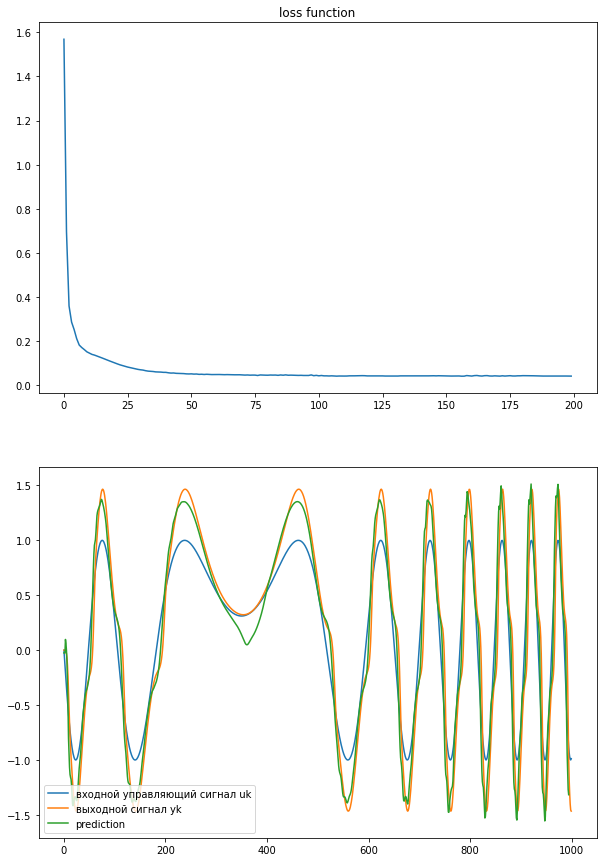

In [ ]:
## 200 эпох


fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(2, 1, 1)

ax.plot(train_loss)
ax.set_title('loss function')

ax = fig.add_subplot(2, 1, 2)

ax.plot(uk, label = 'входной управляющий сигнал uk')
ax.plot(yk, label = 'выходной сигнал yk')
ax.plot(predict, label = 'prediction')

plt.legend()

Количество эпох = 500

In [63]:
model = NARX(in_features = 5, hidden_features = 10, out_features = 5, len_deq1 = 3, len_deq2 = 3)

optim = tr.optim.Adam(model.parameters(), lr = 1e-3)


N, w = 1000, 5
t = np.linspace(0, 10, N)
uk, yk = np.sin(t**2 - 7 * t), [0]
for i in range(N-1):
    yk += [yk[-1] / (1 + yk[-1]**2) + uk[i] ** 3]

train_data = [(np.array(uk[i: i+w], dtype = np.float32), np.array(yk[i: i + w], dtype=np.float32)) for i in range(N - 5)]


train_dataloader = tr.utils.data.DataLoader(dataset = train_data, batch_size = 1, shuffle = False)

model.cuda()

model.train()

train_loss = []

epoch = 500

for i in tqdm(range(epoch)):
    model.clear()

    ep_loss = []

    for inputs, outputs in train_dataloader:
        in_c = inputs.cuda()
        out_c = outputs.cuda()
        out = model(in_c)

        crit = tr.nn.MSELoss()
        loss = tr.sqrt(crit(out_c, out))
        ep_loss += [loss.item()]

        optim.zero_grad()
        loss.backward()
        optim.step()

    train_loss += [np.mean(ep_loss)]


  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-50-a5782a00058c>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.line1.push(tr.tensor(inputs))
<ipython-input-50-a5782a00058c>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.line2.push(tr.tensor(out2))
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 500/500 [13:02<00:00,  1.57s/it]


In [ ]:
model.eval()
model.clear()

predict = []

for inp, out in train_dataloader:
  inp_c = inp.cuda()
  pred = model(inp_c).detach().cpu().numpy().item(-2)
  predict += [pred]

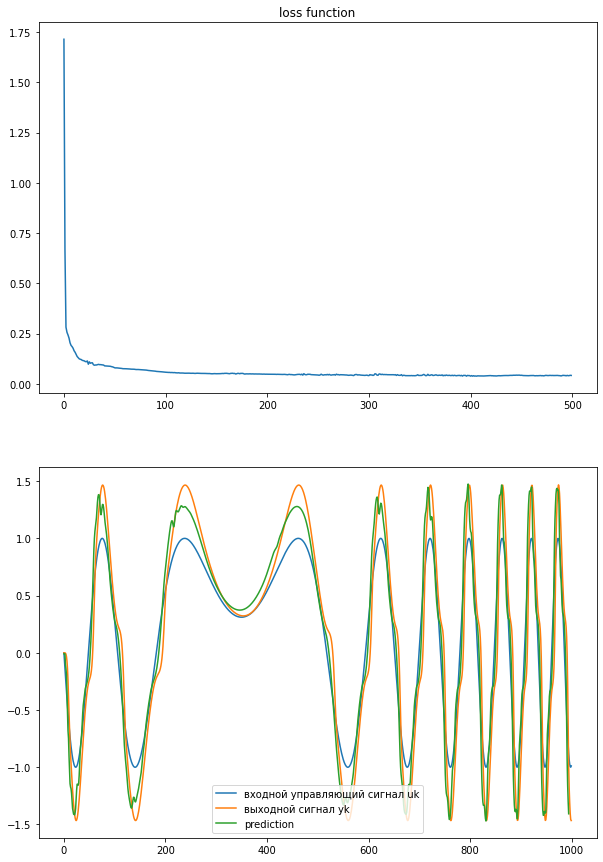

In [65]:
## 500 эпох

fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(2, 1, 1)

ax.plot(train_loss)
ax.set_title('loss function')

ax = fig.add_subplot(2, 1, 2)

ax.plot(uk, label = 'входной управляющий сигнал uk')
ax.plot(yk, label = 'выходной сигнал yk')
ax.plot(predict, label = 'prediction')

plt.legend()

Вывод: В данной лабораторной работе была реализована нелинейная авторегрессионная сеть с внешними входами NARX. Сеть была обучена в течении 200 эпох и в течении 500 эпох. Результаты работы, а также поведение функции потерь при обучениии представлены на графиках.

